## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/test1.png')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/calib3d/src/calibration.cpp:3064: error: (-215) ni == ni1 in function collectCalibrationData


In [7]:
cv2.destroyAllWindows()

## And so on and so forth...

# Perspective Transform 

In [8]:
import pickle 


dist_pickle = pickle.load( open ("../camera_cal/wide_dist_pickle.p", "rb" )  )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    warped, M  = None, None
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

img = cv2.imread('../camera_cal/calibration10.jpg')
nx = 9
ny = 6 
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Sobel Operator 


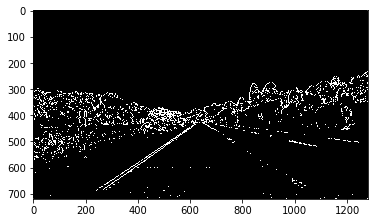

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline

img = mpimg.imread('../test_images/straight_lines1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')


# Combining Thresholds

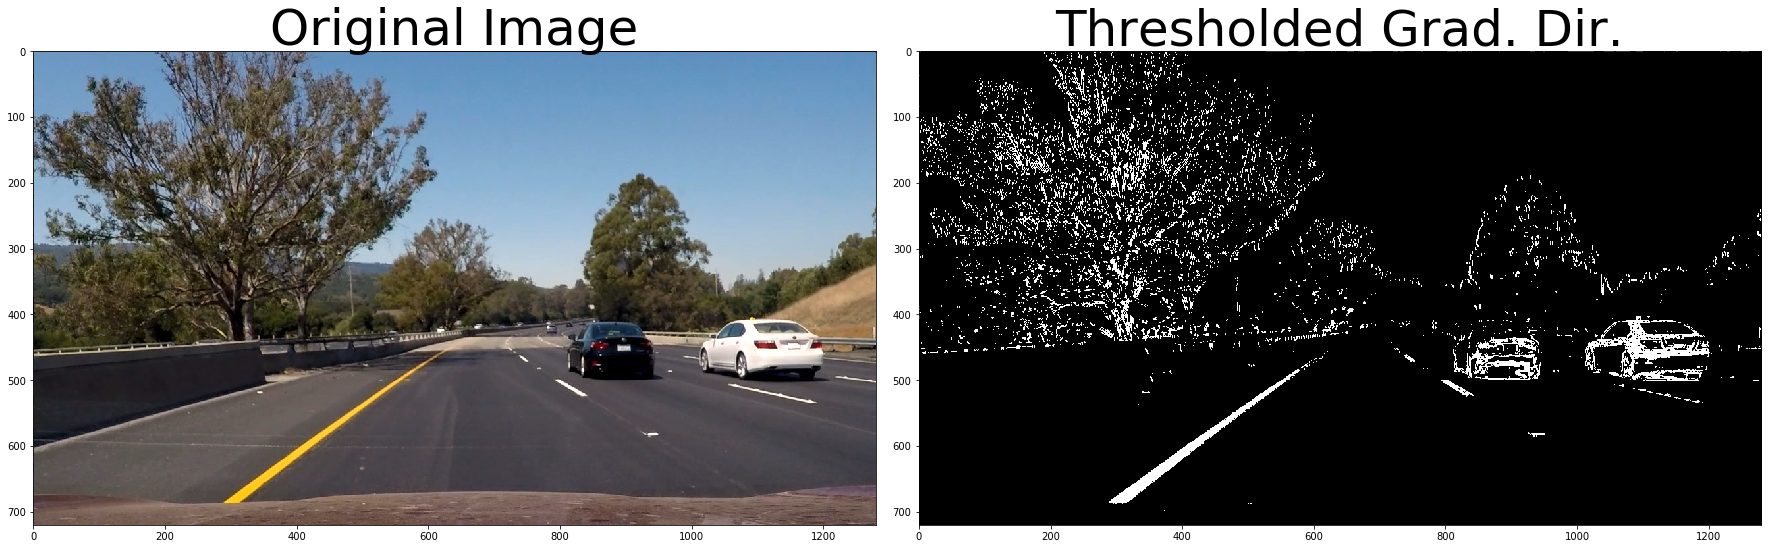

In [10]:
image = mpimg.imread('../test_images/test6.jpg')
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh = (0,255)):
# This function applies sobel x transform to the image
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(direction)
    
    # 6) Return this mask as your binary_output image
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output
def hls_thresh(img,thresh=(100,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def combined_thresh(img):
    #
    abs_bin = abs_sobel_thresh(img, orient='x', thresh=(50,255))
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

    return combined
    
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

combined = combined_thresh(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Obtaining the points for perspective transform and region of interest for lane lines isolation

5
-------------------
[  50 1280]
x_cords [array([  50, 1280], dtype=int32), array([350, 731], dtype=int32), array([370, 731], dtype=int32), array([ 670, 1280], dtype=int32), array([  50, 1280], dtype=int32)]


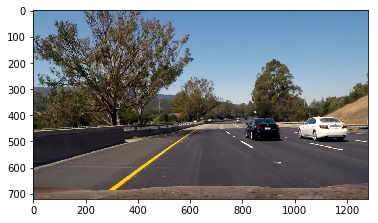

In [11]:
image = mpimg.imread('../test_images/test6.jpg')
def points_calculator(img):
    x_dim = img.shape[0]
    y_dim = img.shape[1]
    vertices = np.array([[(50,y_dim),(x_dim/2-10,y_dim/1.75),(x_dim/2+10,y_dim/1.75),(x_dim-50,y_dim),(50,y_dim)]], dtype=np.int32)
    return vertices

vertices = points_calculator(image)
print(len(vertices[0]))
print("-------------------")
print(vertices[0][0])
x_cords = []
for i in range(len(vertices[0])):
    x_cords.append(vertices[0][i])

print("x_cords",x_cords)
plt.figure()
plt.imshow(image)
#plt.scatter( x = [50,350], y = [1280,731],s=10, c='red', marker='o')
#x = [1280,731,731,1280],y = [50,350,370,670],
plt.show()
    

# Color and Gradient 


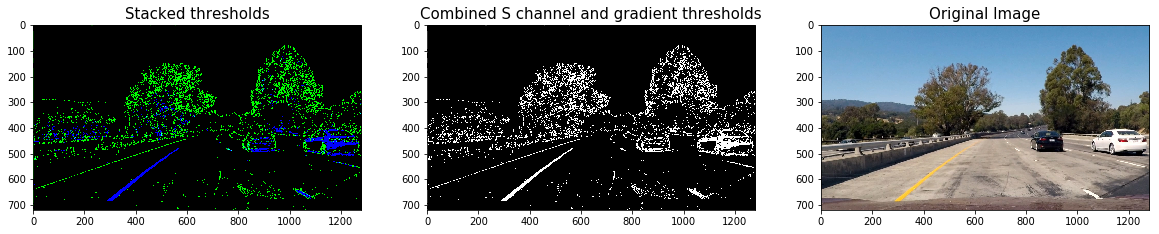

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline

img = mpimg.imread('../test_images/test1.jpg')

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
s_channel = hsv[:,:,2]
l_channel = hsv[:,:,1]
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1


# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Stacked thresholds',fontsize=15)
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds',fontsize=15)
ax2.imshow(combined_binary, cmap='gray')

ax3.set_title('Original Image', fontsize=15)
ax3.imshow(img)


# Perspective Transform on road image

In [13]:
def get_vertices(img):
    x_dim = img.shape[1]
    y_dim = img.shape[0]
    vertices = np.array([[(50,y_dim),(x_dim/2-10,y_dim/1.75),(x_dim/2+10,y_dim/1.75),(x_dim-50,y_dim),(50,y_dim)]], dtype=np.int32)
    return vertices

def region_of_interest(img):
    # get vertices
    vertices = get_vertices(img)
    # defining a blank mask to start with
    mask = np.zeros_like(img)
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 1)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

[[[  50  720]
  [ 630  411]
  [ 650  411]
  [1230  720]
  [  50  720]]]


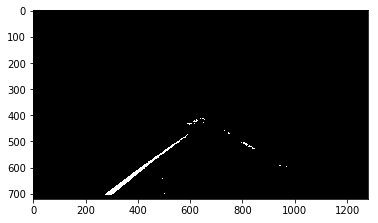

In [14]:
img = mpimg.imread('../test_images/test6.jpg')
print(get_vertices(img))
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(region_of_interest(combined_thresh(undist_img)), cmap='gray')
#mpimg.imsave('output_images/combined_thresh_roi.png', region_of_interest(combined_thresh(undist_img)), cmap='gray')

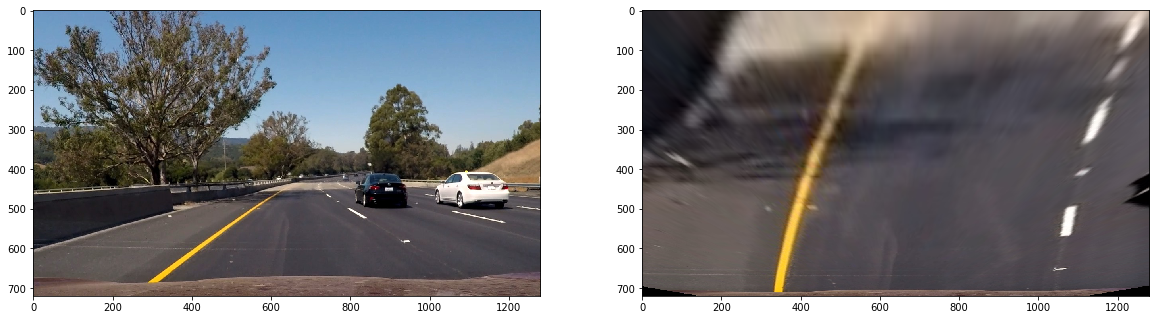

In [15]:
image = mpimg.imread('../test_images/test6.jpg')
#vertices = np.array([[(50,y_dim),(x_dim/2-10,y_dim/1.75),(x_dim/2+10,y_dim/1.75),(x_dim-50,y_dim),(50,y_dim)]], dtype=np.int32)

# Draw source points
src = np.float32([[200, 720],[595, 450],[685, 450],[1100, 720],[200, 720]])
dst = np.float32([[300,720],[300,0],[980,0],[980,720]])
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[200,720],[595,450],[685,450],[1100,720]])
    dst = np.float32([[300,720],[300,0],[980,0],[980,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv, cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)



#mpimg.imsave('output_images/source_points.png', result[0])
minv, persp = perspective_transform(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax2.imshow(persp)


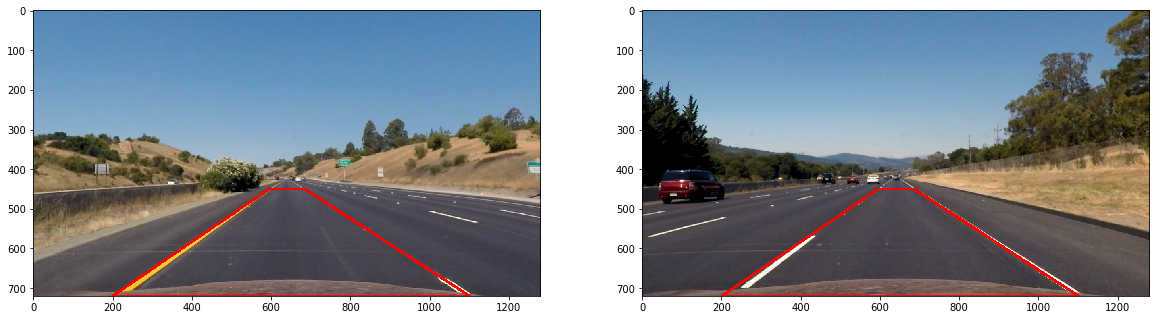

In [16]:
# Draw source points
src = np.float32([[200, 720],[595, 450],[685, 450],[1100, 720],[200, 720]])
images = glob.glob('../test_images/straight_lines*.jpg')
result = []
for fname in images:
    img = mpimg.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    for i in range(len(src)-1):
        cv2.line(img, (src[i][0], src[i][1]), (src[i+1][0], src[i+1][1]), color=[255,0,0], thickness=5)
    result.append(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(result[0])
ax2.imshow(result[1])
mpimg.imsave('../output_images/source_points.png', result[0])

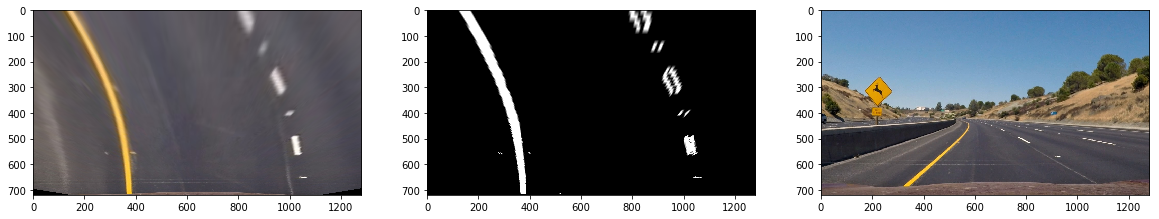

In [17]:
img = mpimg.imread('../test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
_, warped = perspective_transform(undist)
_, binary_warped = perspective_transform(region_of_interest(combined_thresh(undist)))
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title("")
ax2.imshow(binary_warped, cmap='gray')
ax3.imshow(img)
mpimg.imsave('../output_images/warped.png', warped)
mpimg.imsave('../output_images/binary_warped.png', binary_warped, cmap='gray')

# Finding Lane Lines and fitting Polynomial 

(1280, 4)


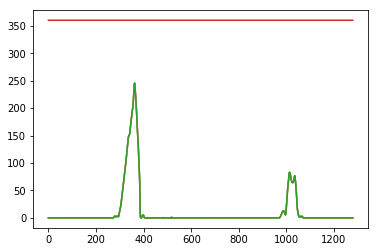

In [18]:
img = mpimg.imread('../output_images/binary_warped.png')
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
print(histogram.shape)

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#binary_warped = mpimg.imread('../output_images/binary_warped.png')
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def find_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds


a,b,c,d,e = find_lines(binary_warped)

(720, 0)

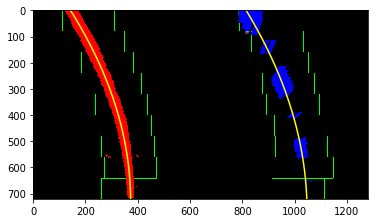

In [20]:

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
# Find the peak of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [21]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

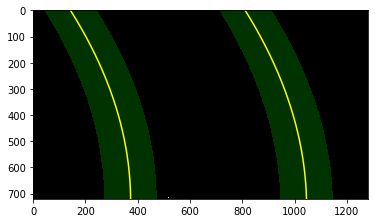

In [22]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

In [24]:
def fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [25]:
def show_lines(binary_warped, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

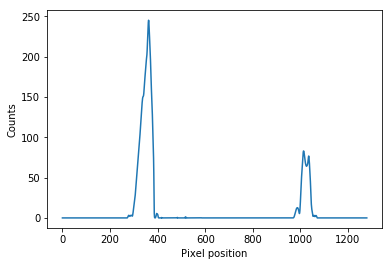

In [26]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.savefig('../output_images/histogram.png')

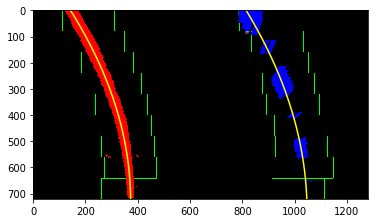

In [27]:
out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
show_lines(binary_warped, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
plt.savefig('../output_images/sliding_window.png')

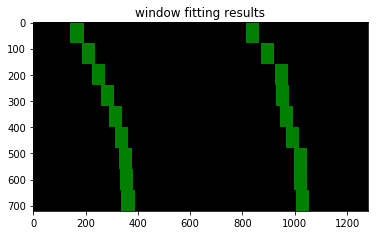

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = binary_warped#mpimg.imread('warped_example.jpg')
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


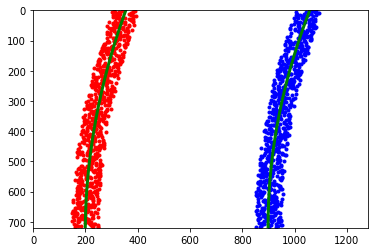

In [29]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [30]:
def get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    y_eval = binary_warped.shape[0]-1
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [31]:
def get_offset(undist, left_fit, right_fit):
    # Calculate vehicle center offset
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return offset * xm_per_pix

In [32]:
def draw_lines(undist, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, offset):
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Curvature: {} m".format(round(left_curverad, 3))
    cv2.putText(result, text, (400, 50), font, 1, (255,255,255), 2)
    text = "Right Curvature: {} m".format(round(right_curverad, 3))
    cv2.putText(result, text, (400, 100), font, 1, (255,255,255), 2)
    text = "Distance from center: {} m".format(round(offset, 3))
    cv2.putText(result, text,(400,150), font, 1, (255,255,255), 2)
    
    return result

In [33]:
def single_pipeline(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = region_of_interest(combined_thresh(undist))
    Minv, binary_warped = perspective_transform(binary)
    _, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    left_curverad, right_curverad = get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    offset = get_offset(undist, left_fit, right_fit)
    return draw_lines(undist, binary_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, offset)

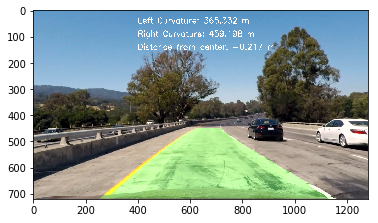

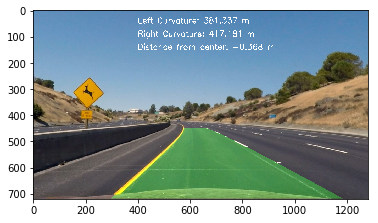

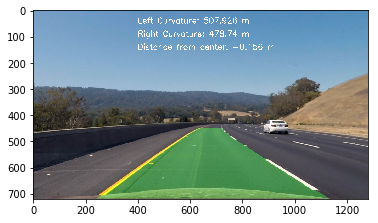

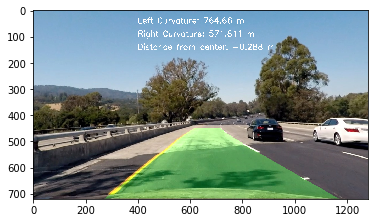

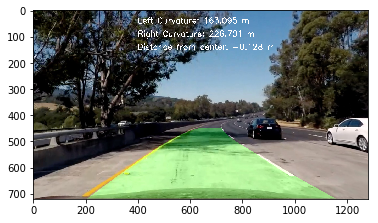

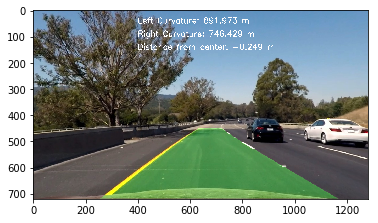

In [34]:
images = glob.glob('../test_images/test*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    plt.imshow(single_pipeline(img, mtx, dist))
    plt.figure()

In [35]:
def find_lines_by_previous(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    return nonzerox, nonzeroy, left_lane_inds, right_lane_inds

In [36]:
def show_lines_by_previous(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin = 100
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

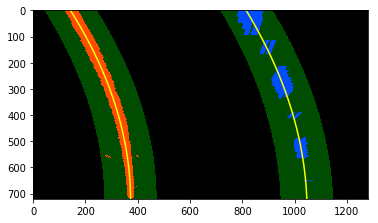

In [37]:
left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines_by_previous(binary_warped, left_fit, right_fit)
show_lines_by_previous(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
plt.savefig('../output_images/skip_sliding_window.png')

In [38]:
from collections import deque

class Lanes():
    def __init__(self):
        self.detected = False
        self.left_fits = deque([], 5)
        self.right_fits = deque([], 5)
        
    def update(self, left_fit, right_fit):
        if self.line_check(left_fit, right_fit):
            self.detected = True
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
        else:
            self.detected = False
            self.left_fits.append(self.left_fits[-1])
            self.right_fits.append(self.right_fits[-1])
        
    def line_check(self, left_fit, right_fit):
        top_y = 0
        top_x_left = left_fit[2]
        top_x_right = right_fit[2]
        bottom_y = 719
        bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
        bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
        
        bottom_diff = bottom_x_right - bottom_x_left
        top_diff = top_x_right - top_x_left
        
        return abs(bottom_diff - top_diff) < 100
    
    def left_fit(self):
        return np.mean(np.array(self.left_fits), axis=0)
    
    def right_fit(self):
        return np.mean(np.array(self.right_fits), axis=0)

lanes = Lanes()
def video_pipeline(img):
    global lanes
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = region_of_interest(combined_thresh(undist))
    Minv, binary_warped = perspective_transform(binary)
    if lanes.detected:
        nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines_by_previous(binary_warped, lanes.left_fit(), lanes.right_fit())
    else:
        _, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lines(binary_warped)
    left_fit, right_fit = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    lanes.update(left_fit, right_fit)
    left_curv, right_curv = get_curverad(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    offset = get_offset(undist, left_fit, right_fit)
    return draw_lines(undist, binary_warped, lanes.left_fit(), lanes.right_fit(), Minv, left_curv, right_curv, offset)


In [41]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = '../project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
video_clip = clip1.fl_image(video_pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [05:43<00:00,  4.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 5min 33s, sys: 1min 14s, total: 6min 47s
Wall time: 5min 44s


In [42]:
import os 
os.system("say regression complete")

0